In [1]:
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)

In [3]:
DEFAULT_FIGSIZE = (14, 7)

In [4]:
records = lidar.load_records(sync=False)

Unable to determine range 2
Unable to determine range 1


In [5]:
import numpy as np
import scipy.signal

fs = 125

# speed filter
def h(x):
    order = 5
    apass = 0.001 # dB
    fcut = 0.5
    wn = fcut / (0.5*fs)
    b, a = scipy.signal.cheby1(order, apass, wn)
    return scipy.signal.filtfilt(b, a, x)

def get_active_trial_index(v):
    MIN_SPEED = 2.8 # [m/s]
    edges = np.diff((v > MIN_SPEED).astype(int))
    edge_index = np.where(edges)[0]
    edge_type = edges[edge_index]
    
    n = len(edge_type)
    assert n > 0
    
    if n == 1 and edge_type[0] == -1:
        # Single falling edge in the second half of the trial.
        # Set rising edge to the first sample.
        assert edge_index[0] > n/2
        return np.insert(edge_index, 0, 0)
    elif n == 2 and edge_type[0] == 1 and edge_type[1] == -1:
        return edge_index
    elif n == 3 and edge_type[0] == -1 and edge_index[0] < 100:
        # Extra falling edge at the beginning on the trial.
        # Remove first falling edge.
        assert edge_type[1] == 1
        assert edge_type[2] == -1
        return edge_index[1:]
    else:
        raise NotImplementedError
        
def active_trial(trial):
    v = h(trial.speed)
    index = get_active_trial_index(v)
    return trial[slice(index[0], index[1])]
    

for i, r in enumerate(records):
    for j, t in enumerate(r.trials()):
        if t is None:
            print('record {}, trial {}, failure'.format(i, j))
            continue
            
        n = len(t)
        m = len(active_trial(t))
        print('record {}, trial {}, samples {} -> {}, {:0.2f}%'.format(i, j, n, m, m/n*100))

record 0, trial 0, failure
record 0, trial 1, failure
record 0, trial 2, samples 3102 -> 2457, 79.21%
record 0, trial 3, samples 3972 -> 3376, 84.99%
record 0, trial 4, samples 3427 -> 2542, 74.18%
record 0, trial 5, samples 3067 -> 2329, 75.94%
record 0, trial 6, samples 3791 -> 3042, 80.24%
record 0, trial 7, samples 3307 -> 2654, 80.25%
record 0, trial 8, samples 2861 -> 2246, 78.50%
record 0, trial 9, samples 3901 -> 3221, 82.57%
record 0, trial 10, samples 3300 -> 2716, 82.30%
record 0, trial 11, samples 2914 -> 2338, 80.23%
record 0, trial 12, samples 4046 -> 3396, 83.93%
record 0, trial 13, samples 3219 -> 2669, 82.91%
record 0, trial 14, samples 2913 -> 2297, 78.85%
record 1, trial 0, samples 4652 -> 3514, 75.54%
record 1, trial 1, samples 3461 -> 2501, 72.26%
record 1, trial 2, samples 3536 -> 2780, 78.62%
record 1, trial 3, samples 4202 -> 3538, 84.20%
record 1, trial 4, samples 3206 -> 2308, 71.99%
record 1, trial 5, samples 3405 -> 2748, 80.70%
record 1, trial 6, samples 43

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


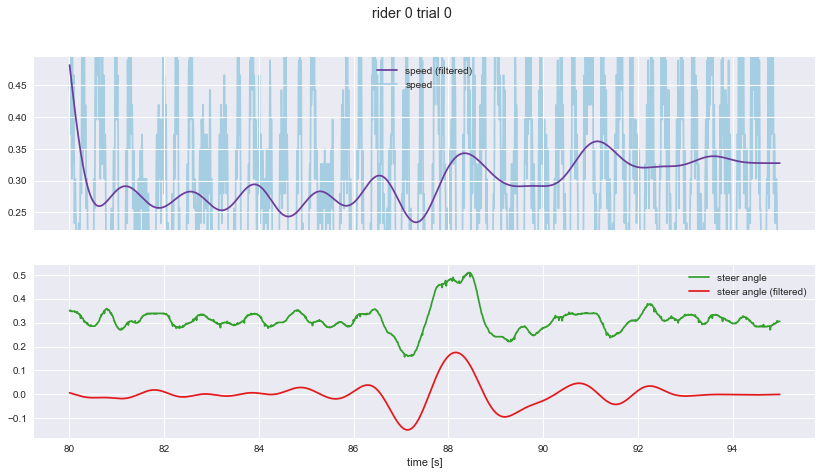

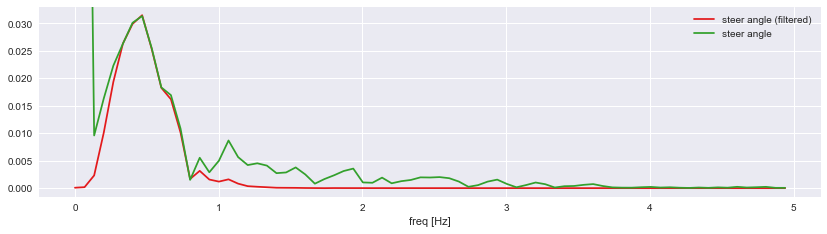

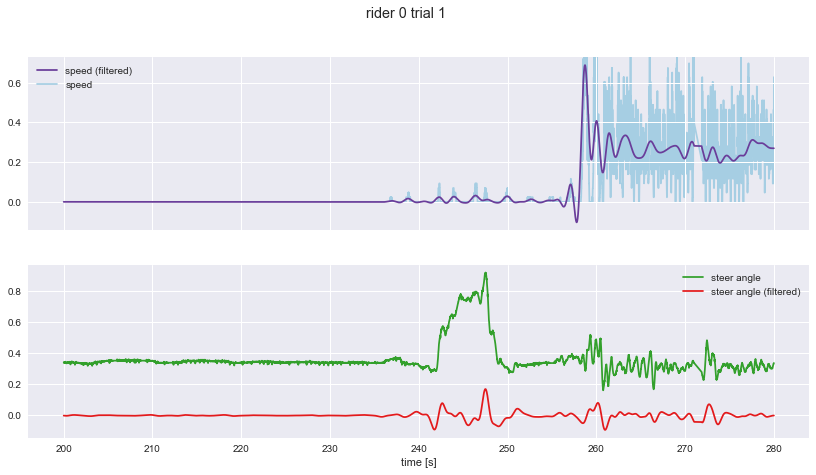

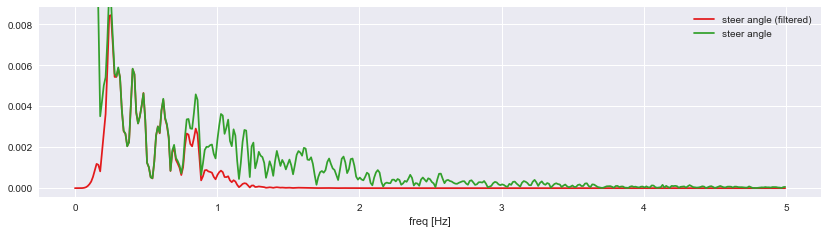

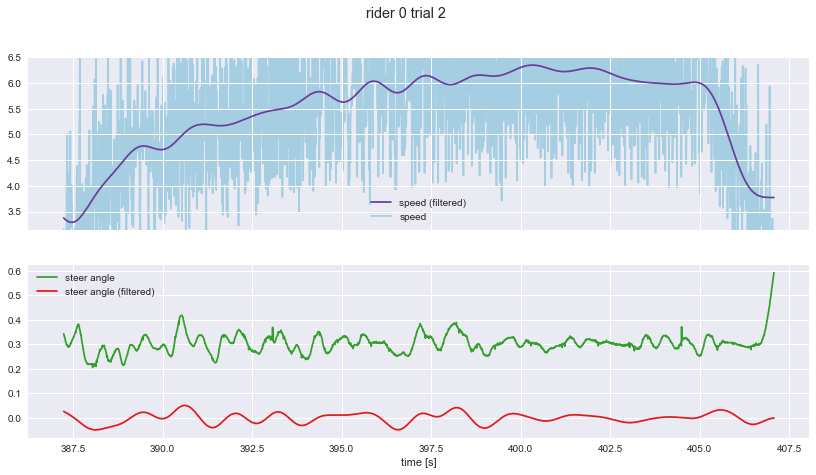

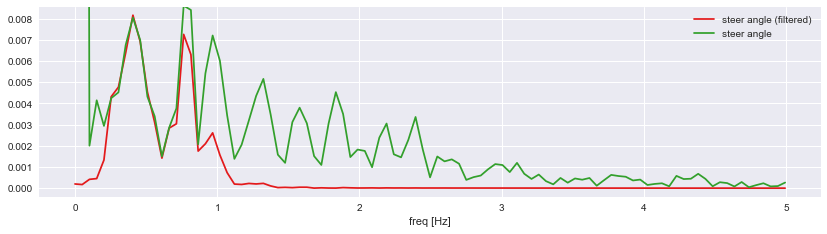

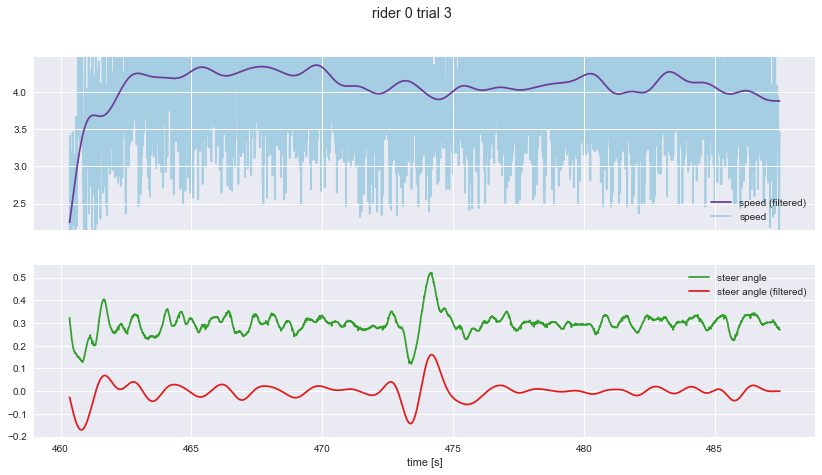

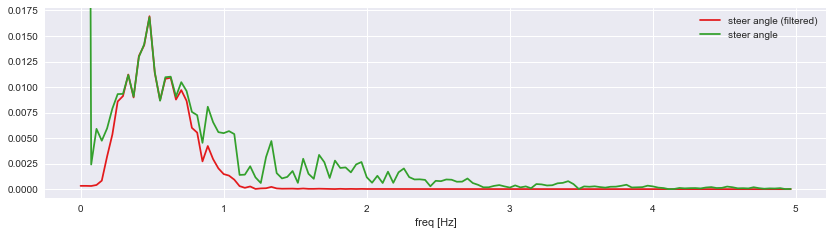

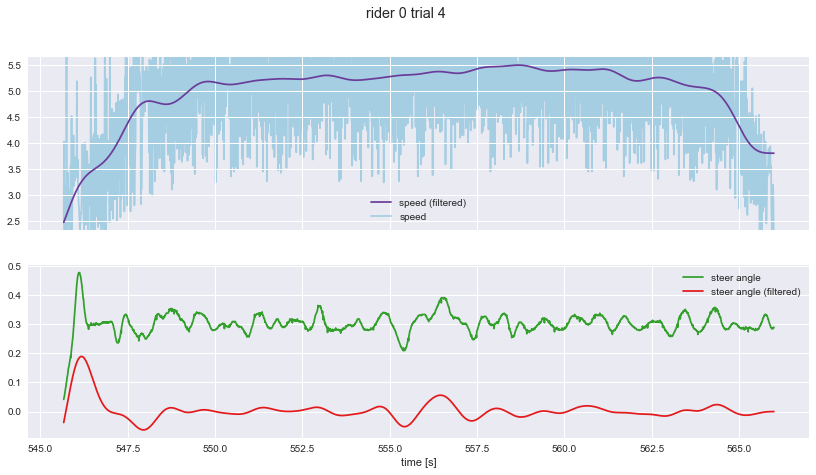

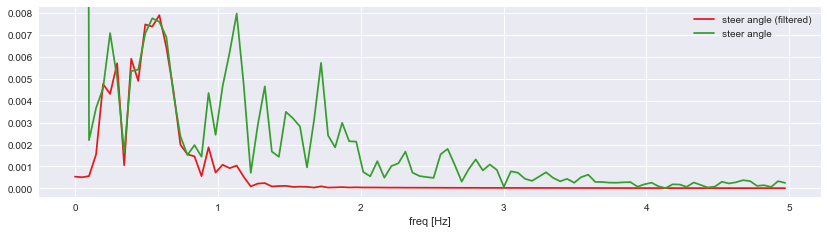

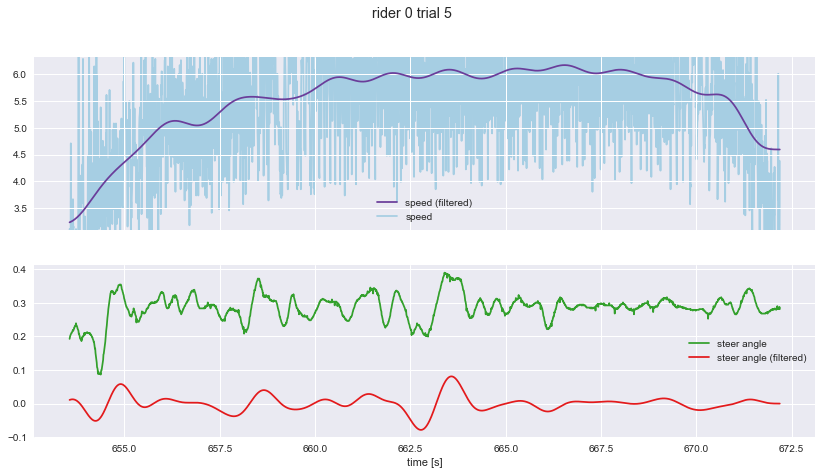

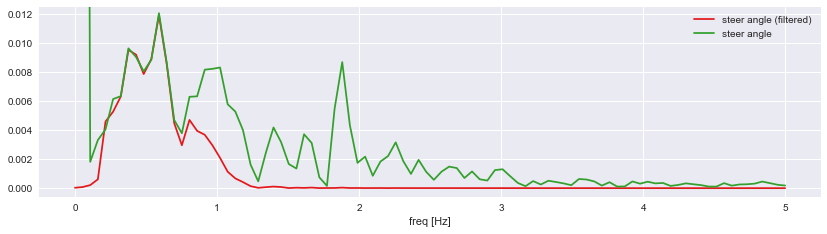

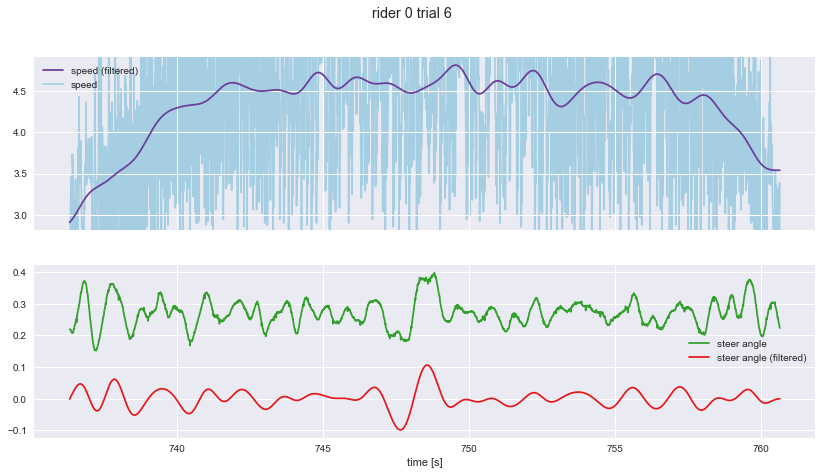

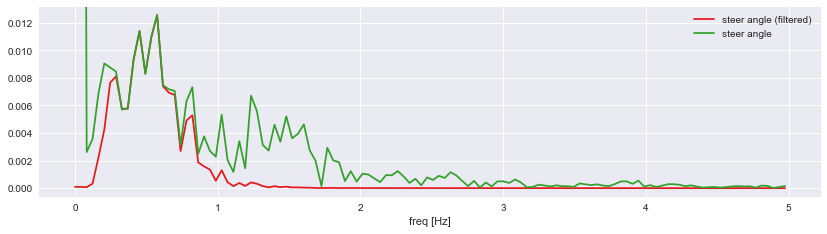

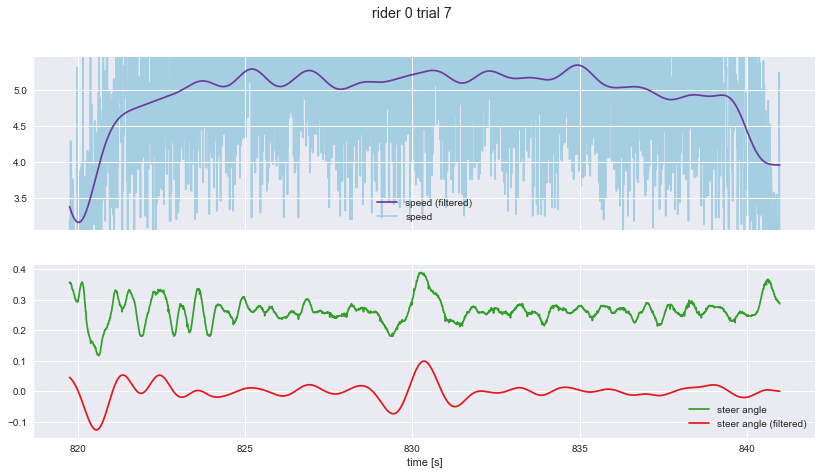

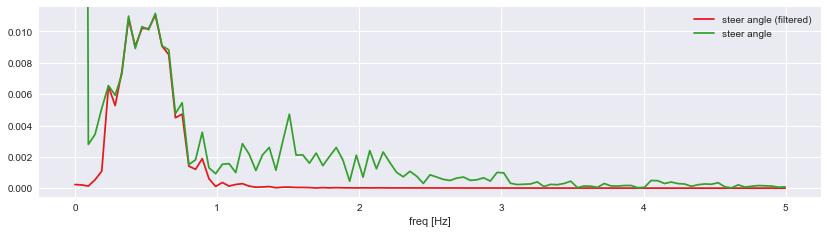

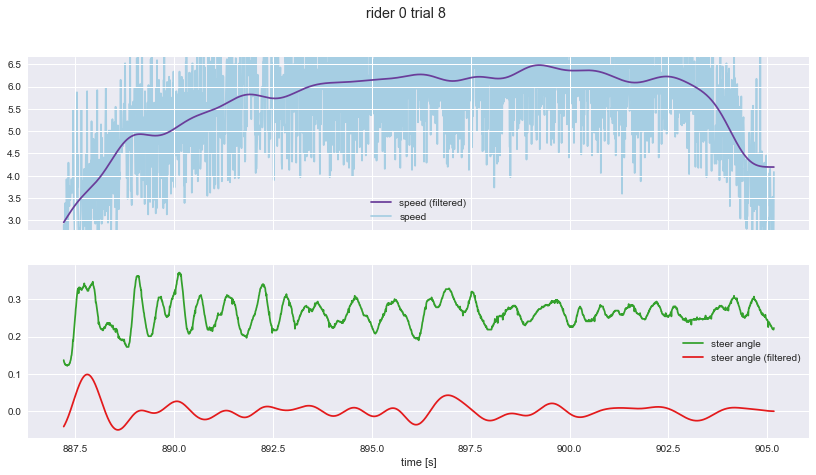

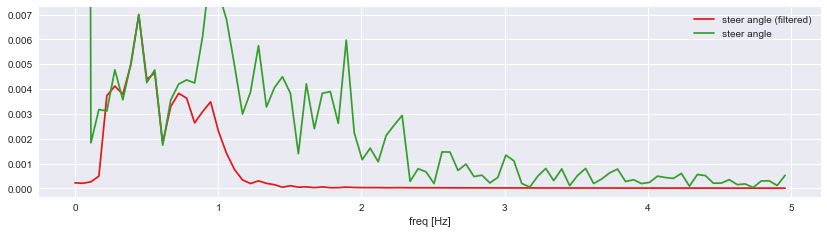

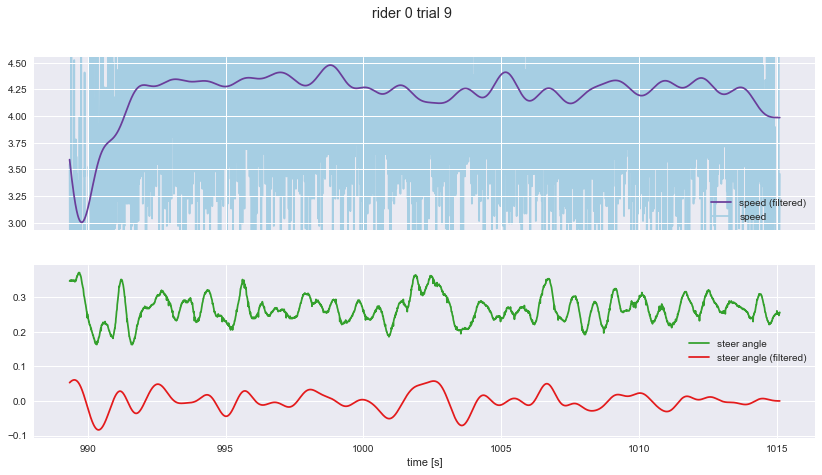

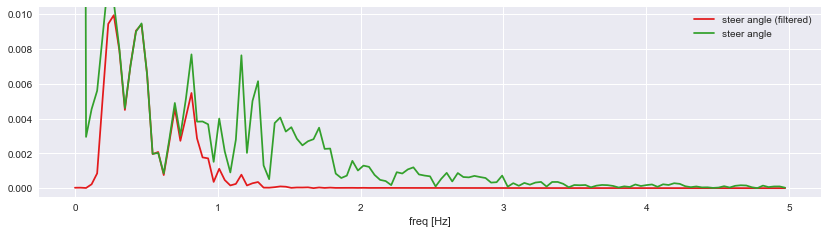

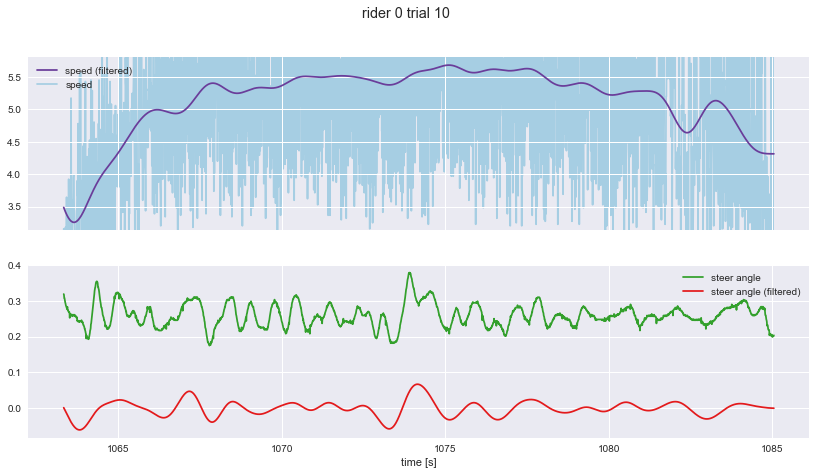

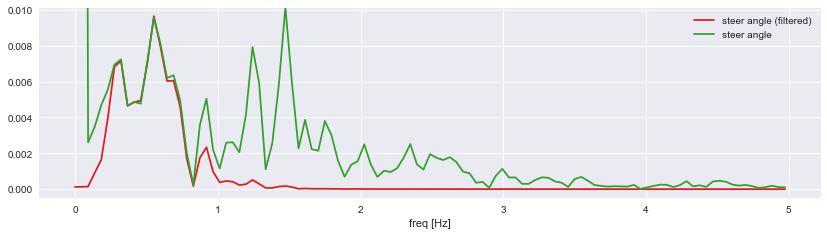

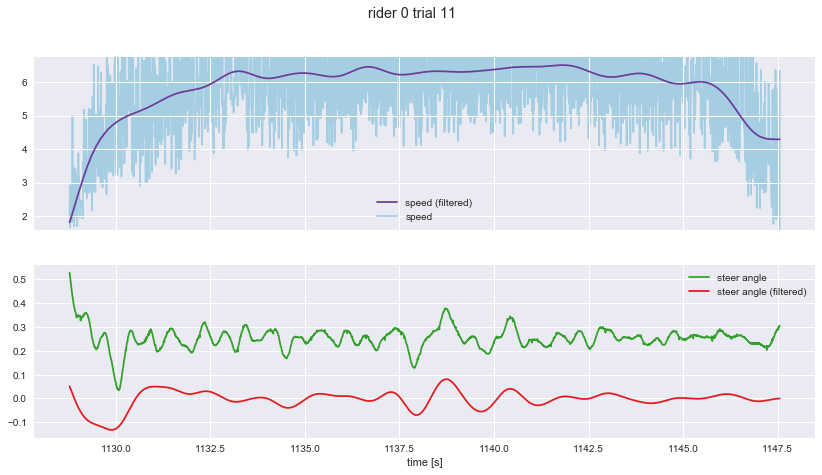

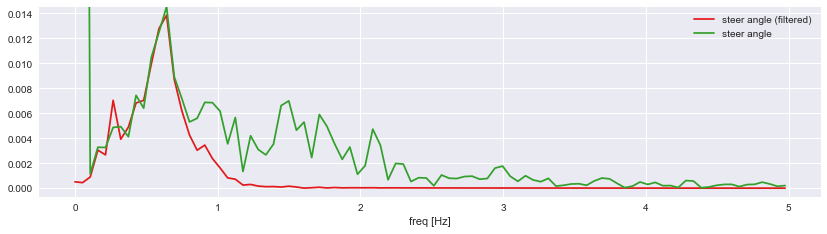

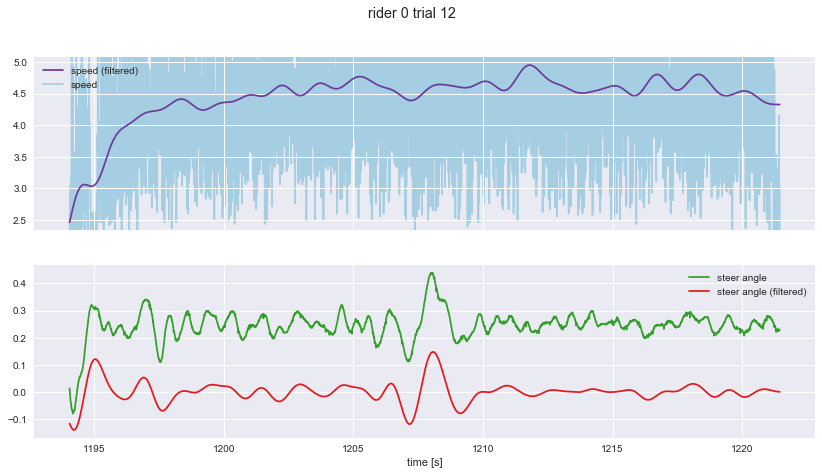

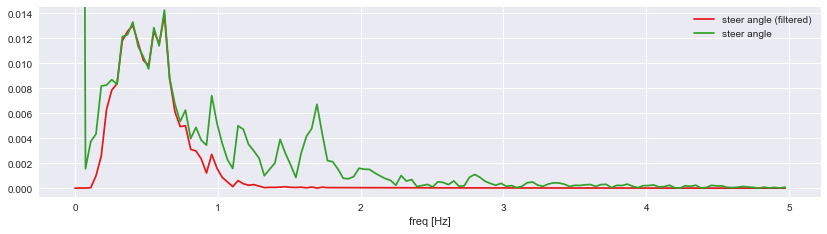

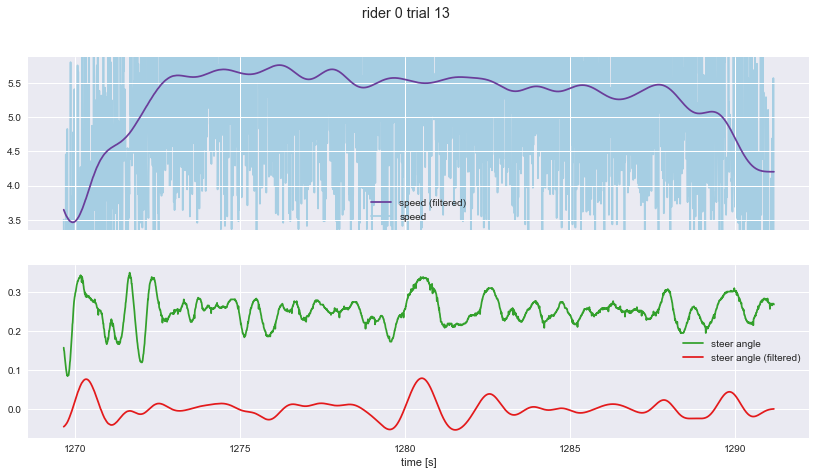

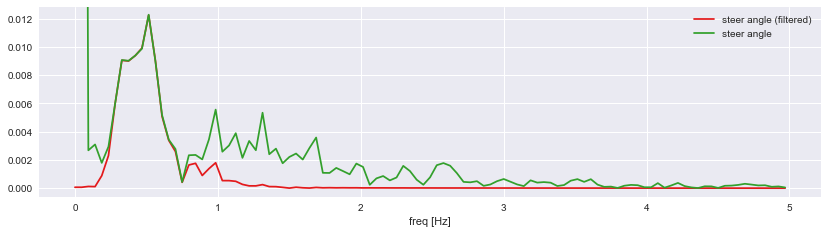

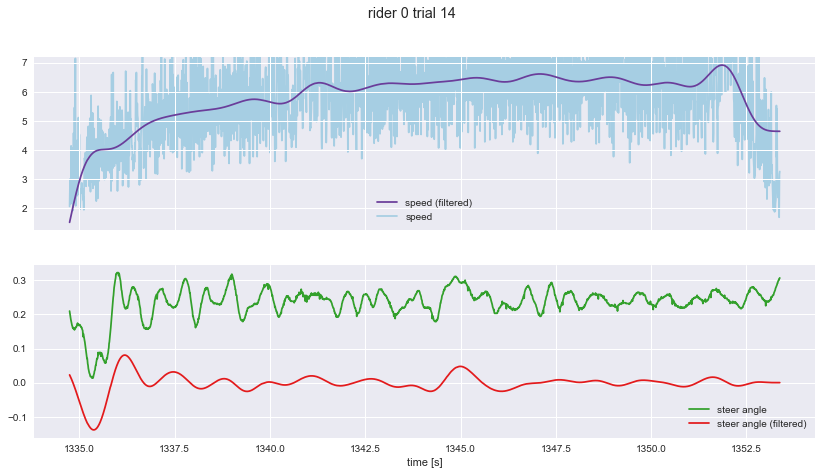

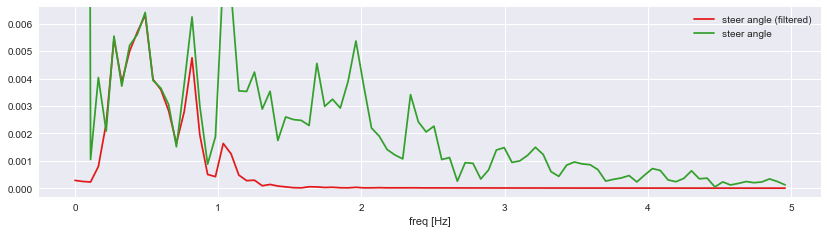

In [6]:
import numpy as np
import seaborn as sns
colors = sns.color_palette('Paired', 12)

from antlia.filter import fft
import scipy.signal

fs = 125 # sample frequency in Hz

# steer angle filter
def f(x):
    order = 3
    fcut = np.array([0.2, 0.9]) # Hz
    wn = fcut / (0.5 * fs)
    b, a = scipy.signal.butter(order, wn, btype='bandpass')
    return scipy.signal.filtfilt(b, a, x)

# maximum frequency to plot
max_freq = 5 # Hz
def g(x):
    freq, xf = fft(x, 1/fs)
    return freq[freq < max_freq], xf[freq < max_freq]

# speed filter
def h(x):
    order = 5
    apass = 0.001 # dB
    fcut = 0.5
    wn = fcut / (0.5*fs)
    b, a = scipy.signal.cheby1(order, apass, wn)
    return scipy.signal.filtfilt(b, a, x)

rid = 0
r = records[rid]
for tid in range(15):
    try:
        trial = active_trial(r.trial(tid))
    except TypeError:
        trial = r.trial(tid, 0)
        if r == records[0]:
            if tid == 0:
                index = (trial.time > 80) & (trial.time < 95)
            elif tid == 1:
                index = (trial.time > 200) & (trial.time < 280)
        trial = trial[index]
    
    v = h(trial.speed)
    y = f(trial['steer angle'])
    
    _, ax = plt.subplots(2, 1, sharex=True, figsize=DEFAULT_FIGSIZE)
    ax[0].plot(trial.time, v, label='speed (filtered)',
               color=colors[9], zorder=1)
    ylim = ax[0].get_ylim()
    ax[0].plot(trial.time, trial.speed, label='speed',
               color=colors[0], zorder=0)
    ax[0].set_ylim(ylim[0], ylim[1])
    
    ax[1].plot(trial.time, trial['steer angle'],
               color=colors[3], label='steer angle')
    ax[1].plot(trial.time, y,
               color=colors[5], label='steer angle (filtered)')
    for axi in ax:
        axi.legend()
    ax[1].set_xlabel('time [s]')
    set_title(ax[0], 'rider {} trial {}'.format(rid, tid))
    
    _, ax = plt.subplots(figsize=(DEFAULT_FIGSIZE[0], DEFAULT_FIGSIZE[1]/2))
    ax.plot(*g(y), color=colors[5], label='steer angle (filtered)')
    ylim = ax.get_ylim()
    
    ax.plot(*g(trial['steer angle']), color=colors[3], label='steer angle')
    #ax.plot(*g(trial.speed), color=colors[0], label='speed')
    #ax.plot(*g(v), color=colors[9], label='speed (filtered)')
    ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_xlabel('freq [Hz]')
    ax.legend()
plt.show()